# Outline
1. Goal: Prediction of residential prices based on various features
2. Info: We can see results of prediction by not only base estimators but also LighbGBM.

# Import libraries and data

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, Binarizer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

from lightgbm import LGBMRegressor, plot_importance

import graphviz

In [2]:
# Unzip archive
!unzip -o archive.zip

Archive:  archive.zip
  inflating: Equity_Apartments_Data.csv  


In [3]:
# Load data
data = pd.read_csv('Equity_Apartments_Data.csv')
data

,Unnamed: 0,Price,Beds,Baths,sq.ft,Floor,Move_in_date,building_id,unit_id,URL,...,Fireplace,City_Skyline,Kitchen_Island,Stainless_Appliances,Renovated,Office_Space,Days_Till_Available,Day_of_the_week_recorded,Unique_ID,Estiamted_Vacancy
0,1,2377,0,1.0,523,5,2021-09-02,01,0507,https://www.equityapartments.com/washington-dc...,...,0.0,0.0,0.0,1.0,1.0,0.0,47.0,Wednesday,0105071210MassApartments,0.020833
1,2,2816,1,1.0,713,2,2021-09-13,01,0204,https://www.equityapartments.com/washington-dc...,...,0.0,0.0,0.0,1.0,1.0,0.0,58.0,Wednesday,0102041210MassApartments,0.020833
2,3,3811,2,2.0,1252,6,2021-10-08,01,0608,https://www.equityapartments.com/washington-dc...,...,1.0,0.0,0.0,0.0,0.0,0.0,83.0,Wednesday,0106081210MassApartments,0.020833
3,4,1549,0,1.0,456,2,2021-09-17,1,256 \r\n,https://www.equityapartments.com/washington-dc...,...,0.0,0.0,0.0,0.0,0.0,0.0,62.0,Wednesday,1256\r\n1500MassApartments,0.003597
4,5,1753,1,1.0,580,3,2021-10-05,1,337 \r\n,https://www.equityapartments.com/washington-dc...,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,Wednesday,1337\r\n1500MassApartments,0.003597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62805,62806,3062,2,2.0,1203,6,2021-06-29,NaN,NaN,https://www.equityapartments.com/arlington/cou...,...,0.0,0.0,0.0,0.0,0.0,0.0,13.0,Sunday,NaN,0.032828
62806,62807,3150,2,2.0,1203,5,2021-07-17,NaN,NaN,https://www.equityapartments.com/arlington/cou...,...,0.0,0.0,0.0,0.0,0.0,0.0,31.0,Sunday,NaN,0.032828
62807,62808,3154,2,2.0,1080,19,2021-07-27,NaN,NaN,https://www.equityapartments.com/arlington/cou...,...,0.0,0.0,0.0,0.0,0.0,0.0,41.0,Sunday,NaN,0.032828
62808,62809,3158,2,2.0,1209,7,2021-08-21,NaN,NaN,https://www.equityapartments.com/arlington/cou...,...,0.0,0.0,0.0,0.0,0.0,0.0,66.0,Sunday,NaN,0.032828


## Dataset Overview
|           Index          |                         Description                         |
|:------------------------:|:-----------------------------------------------------------:|
|           Price          | Price (recorded daily)                                      |
|           Beds           | # of Beds in an apartment. 0 means a studio apt.            |
|           Baths          | # of baths in an apartment.                                 |
|           sq.ft          | # of square feet.                                           |
|           Floor          | Floor                                                       |
|       Move_in_date       | Date the apartment was available for move in.               |
|        building_id       | for apartments that had multiple buildings.                 |
|          unit_id         | The apartment unit number.                                  |
|            URL           | URL that was scraped.                                       |
|       Day_Recorded       | Day the row of data was scraped.                            |
|          Amenity         | Text field describing different apartment features.         |
|      Apartment Name      | Name of the apartment complex.                              |
|          Address         | Address of apartment complex.                               |
|           City           | City the apartment is in.                                   |
|           Units          | Number of units the apartment complex as a whole has.       |
|     Northern_Exposure    | 1 if apartment has northern exposure, 0 otherwise.          |
|     Southern_Exposure    | 1 if apartment has southern exposure, 0 otherwise.          |
|     Eastern_Exposure     | 1 if apartment has eastern exposure, 0 otherwise            |
|     Western_Exposure     | 1 if apartment has western exposure, 0 otherwise.           |
|          Balcony         | 1 if apartment has balcony, 0 otherwise.                    |
|      Walk_In_Closet      | 1 if apartment has walk in closet, 0 otherwise.             |
|         Fireplace        | 1 if apartment has fireplace, 0 otherwise.                  |
|       City_Skyline       | 1 if apartment has city skyline, 0 otherwise.               |
|      Kitchen_Island      | 1 if apartment has kitchen island, 0 otherwise.             |
|   Stainless_Appliances   | 1 if apartment has stainless steel appliances, 0 otherwise. |
|         Renovated        | 1 if apartment has been rennovated, 0 otherwise.            |
|       Office_Space       | 1 if apartment has office space, 0 otherwise.               |
|    Days_Till_Available   | Days until you could move in.                               |
| Day_of_the_week_recorded | What day of the week was the data scraped.                  |
|         Unique_ID        | Unique ID to identify the same apartment over many days.    |
|     Estiamted_Vacancy    | # of obvs that day/ total units for that apartment          |

# Data Preprocessing

In [4]:
# Check wheter data contains NaN or Null
data.isnull().sum()

Unnamed: 0                     0
Price                          0
Beds                           0
Baths                          0
sq.ft                          0
Floor                          0
Move_in_date                 788
building_id                  852
unit_id                      852
URL                            0
Day_Recorded                   0
Amenity                     2491
Apartment Name                 0
Address                        0
City                           0
Units                          0
Northern_Exposure           2491
Southern_Exposure           2491
Eastern_Exposure            2491
Western_Exposure            2491
Balcony                     2491
Walk_In_Closet              2491
Fireplace                   2491
City_Skyline                2491
Kitchen_Island              2491
Stainless_Appliances        2491
Renovated                   2491
Office_Space                2491
Days_Till_Available          788
Day_of_the_week_recorded       0
Unique_ID 

In [5]:
# Drop rows which contain NaN or Null
data.dropna(axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)
data

,Unnamed: 0,Price,Beds,Baths,sq.ft,Floor,Move_in_date,building_id,unit_id,URL,...,Fireplace,City_Skyline,Kitchen_Island,Stainless_Appliances,Renovated,Office_Space,Days_Till_Available,Day_of_the_week_recorded,Unique_ID,Estiamted_Vacancy
0,1,2377,0,1.0,523,5,2021-09-02,01,0507,https://www.equityapartments.com/washington-dc...,...,0.0,0.0,0.0,1.0,1.0,0.0,47.0,Wednesday,0105071210MassApartments,0.020833
1,2,2816,1,1.0,713,2,2021-09-13,01,0204,https://www.equityapartments.com/washington-dc...,...,0.0,0.0,0.0,1.0,1.0,0.0,58.0,Wednesday,0102041210MassApartments,0.020833
2,3,3811,2,2.0,1252,6,2021-10-08,01,0608,https://www.equityapartments.com/washington-dc...,...,1.0,0.0,0.0,0.0,0.0,0.0,83.0,Wednesday,0106081210MassApartments,0.020833
3,4,1549,0,1.0,456,2,2021-09-17,1,256 \r\n,https://www.equityapartments.com/washington-dc...,...,0.0,0.0,0.0,0.0,0.0,0.0,62.0,Wednesday,1256\r\n1500MassApartments,0.003597
4,5,1753,1,1.0,580,3,2021-10-05,1,337 \r\n,https://www.equityapartments.com/washington-dc...,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,Wednesday,1337\r\n1500MassApartments,0.003597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58708,62201,2093,1,1.0,619,11,2021-09-04,01,1103,https://www.equityapartments.com/arlington/cry...,...,0.0,0.0,0.0,0.0,0.0,0.0,71.0,Monday,011103\r\nCrystalPlaceApartments,0.066298
58709,62202,2220,1,1.0,720,11,2021-07-24,01,1101,https://www.equityapartments.com/arlington/cry...,...,0.0,0.0,0.0,0.0,0.0,0.0,29.0,Monday,011101\r\nCrystalPlaceApartments,0.066298
58710,62203,2286,1,1.0,720,2,2021-08-10,01,0201,https://www.equityapartments.com/arlington/cry...,...,0.0,0.0,0.0,0.0,0.0,0.0,46.0,Monday,010201\r\nCrystalPlaceApartments,0.066298
58711,62204,2670,2,2.0,1002,6,2021-09-11,01,0605,https://www.equityapartments.com/arlington/cry...,...,0.0,0.0,0.0,0.0,0.0,0.0,78.0,Monday,010605\r\nCrystalPlaceApartments,0.066298


In [6]:
# Check what columns does data have
data.columns

Index(['Unnamed: 0', 'Price', 'Beds', 'Baths', 'sq.ft', 'Floor',
       'Move_in_date', 'building_id', 'unit_id', 'URL', 'Day_Recorded',
       'Amenity', 'Apartment Name', 'Address', 'City', 'Units',
       'Northern_Exposure', 'Southern_Exposure', 'Eastern_Exposure',
       'Western_Exposure', 'Balcony', 'Walk_In_Closet', 'Fireplace',
       'City_Skyline', 'Kitchen_Island', 'Stainless_Appliances', 'Renovated',
       'Office_Space', 'Days_Till_Available', 'Day_of_the_week_recorded',
       'Unique_ID', 'Estiamted_Vacancy'],
      dtype='object')

In [7]:
# Drop unnecessary columns
columns_drop = ['Unnamed: 0', 'Move_in_date', 'building_id', 'unit_id', 'URL', 'Day_Recorded', 'Amenity', 'Apartment Name', 'Address', 'Day_of_the_week_recorded', 'Unique_ID', 'Estiamted_Vacancy']
data.drop(columns=columns_drop, axis=1, inplace=True)
data

,Price,Beds,Baths,sq.ft,Floor,City,Units,Northern_Exposure,Southern_Exposure,Eastern_Exposure,Western_Exposure,Balcony,Walk_In_Closet,Fireplace,City_Skyline,Kitchen_Island,Stainless_Appliances,Renovated,Office_Space,Days_Till_Available
0,2377,0,1.0,523,5,Washington DC,144,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,47.0
1,2816,1,1.0,713,2,Washington DC,144,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,58.0
2,3811,2,2.0,1252,6,Washington DC,144,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,83.0
3,1549,0,1.0,456,2,Washington DC,556,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0
4,1753,1,1.0,580,3,Washington DC,556,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58708,2093,1,1.0,619,11,Washington DC,181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0
58709,2220,1,1.0,720,11,Washington DC,181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
58710,2286,1,1.0,720,2,Washington DC,181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0
58711,2670,2,2.0,1002,6,Washington DC,181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0


# Visualization

Text(0.5, 1.0, 'Distribution of Price')

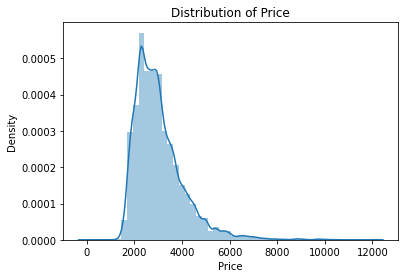

In [8]:
# Check distribution of 'Price'
sns.distplot(data['Price'])
plt.title('Distribution of Price')

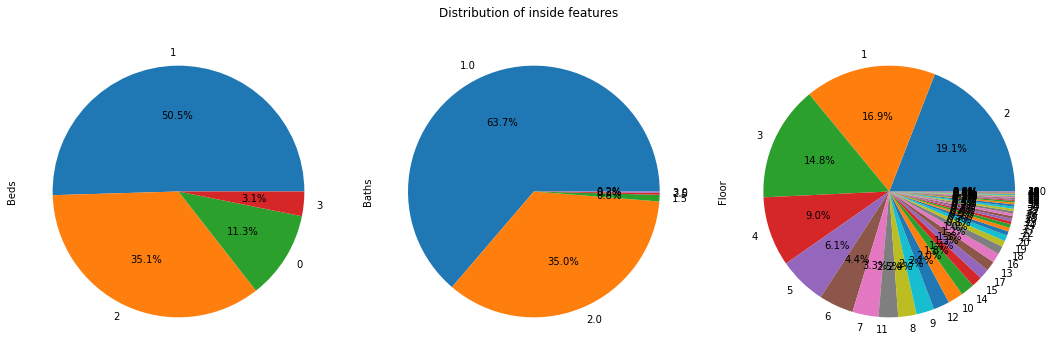

In [38]:
# Plot pie charts indicate features of inside 
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

inside_features = ['Beds', 'Baths', 'Floor']

for i, feature in enumerate(inside_features):
    cols=i%3
    pd.value_counts(data[feature]).plot.pie(autopct="%.1f%%", ax=axs[cols])

plt.suptitle('Distribution of inside features')
plt.tight_layout()

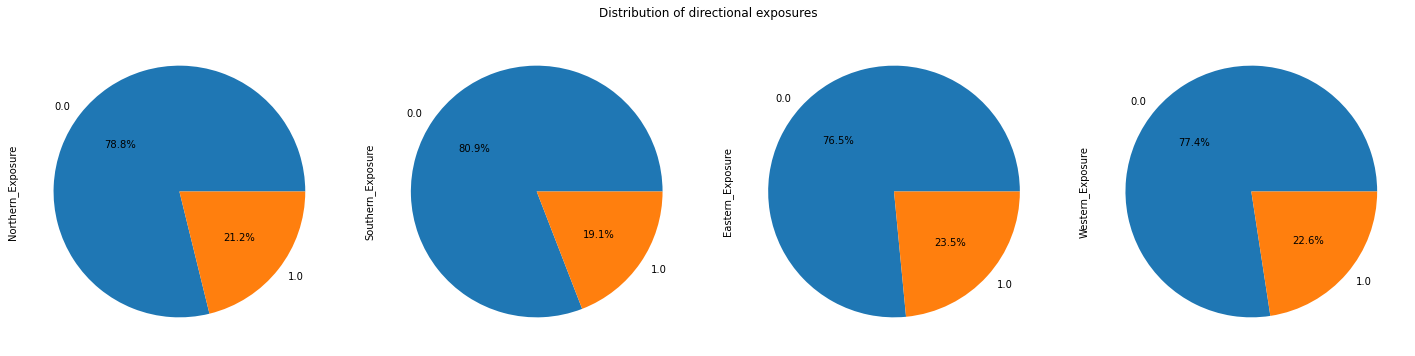

In [10]:
# Plot pie charts indicate features of inside 
fig, axs = plt.subplots(ncols=4, figsize=(20, 5))

exposures = ['Northern_Exposure', 'Southern_Exposure', 'Eastern_Exposure', 'Western_Exposure']

for i, exposure in enumerate(exposures):
    cols=i%4
    pd.value_counts(data[exposure]).plot.pie(autopct="%.1f%%", ax=axs[cols])

plt.suptitle('Distribution of directional exposures')
plt.tight_layout()

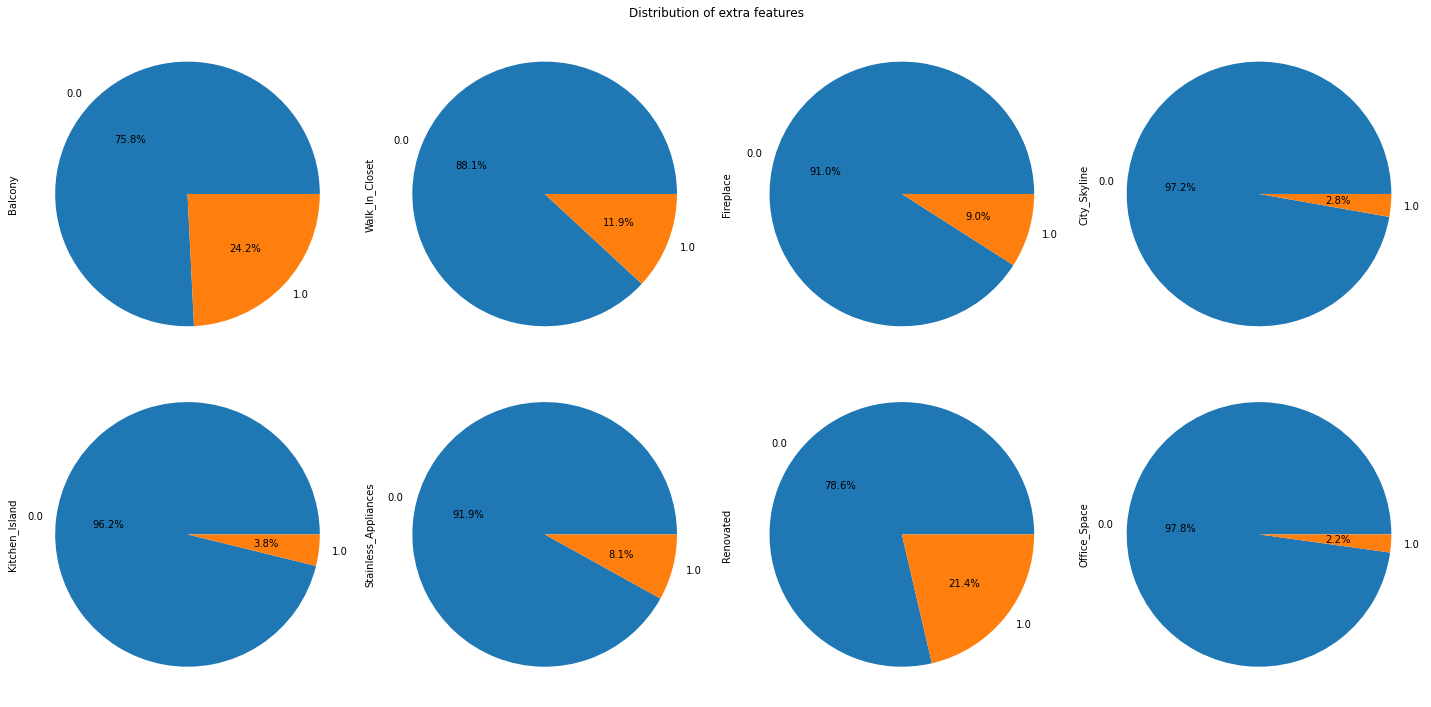

In [11]:
# Plot pie charts indicate extra features
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

extras = ['Balcony', 'Walk_In_Closet', 'Fireplace', 'City_Skyline', 'Kitchen_Island', 'Stainless_Appliances', 'Renovated', 'Office_Space']

for i, extra in enumerate(extras):
    rows=int(i/4)
    cols=i%4
    pd.value_counts(data[extra]).plot.pie(autopct="%.1f%%", ax=axs[rows][cols])

plt.suptitle('Distribution of extra features')
plt.tight_layout()

# Decomposition

<AxesSubplot:title={'center':'Correlation of residential features'}>

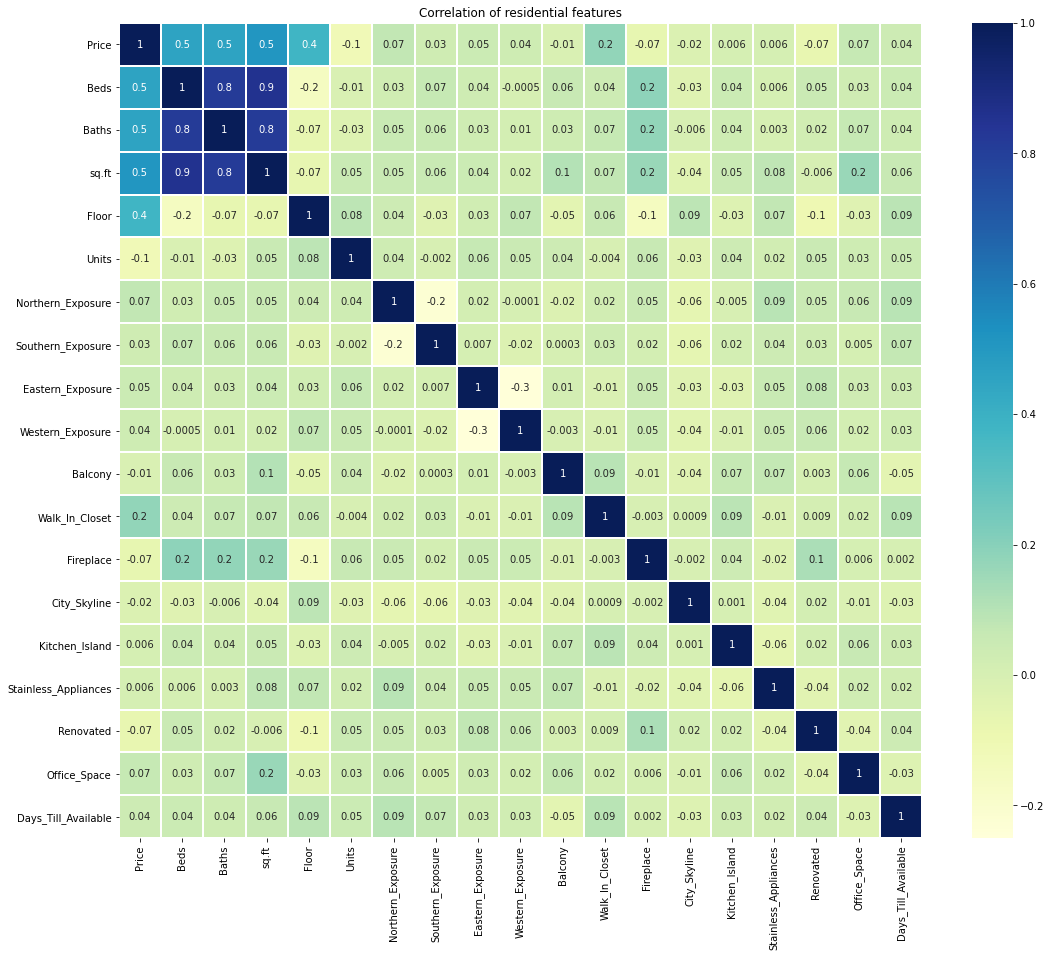

In [35]:
# Correlation Heatmap
fig, ax = plt.subplots(figsize=(18, 15))
plt.title('Correlation of residential features')
sns.heatmap(data.corr(), annot=True, fmt='.1g', linewidths=.3, cmap='YlGnBu')

In [13]:
# Check variances by features
decom_features = ['Beds', 'Baths', 'sq.ft', 'Balcony', 'Fireplace', 'Office_Space']

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[decom_features])
pca = PCA(n_components=2)
pca.fit(data_scaled)
print('Variance by PCA components: ', pca.explained_variance_ratio_)
print('Total Variance by PCA: ', np.round(pca.explained_variance_ratio_.sum(), 3))

Variance by PCA components:  [0.45568766 0.17744685]
Total Variance by PCA:  0.633


# Split Datasets

In [14]:
# Process One-Hot Encoding
data_ohe = pd.get_dummies(data)
data_ohe

,Price,Beds,Baths,sq.ft,Floor,Units,Northern_Exposure,Southern_Exposure,Eastern_Exposure,Western_Exposure,...,City_Boston,City_Denver,City_Inland Empire,City_Los Angeles,City_New York City,City_Orange County,City_San Diego,City_San Francisco,City_Seattle,City_Washington DC
0,2377,0,1.0,523,5,144,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,2816,1,1.0,713,2,144,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,3811,2,2.0,1252,6,144,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
3,1549,0,1.0,456,2,556,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,1753,1,1.0,580,3,556,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58708,2093,1,1.0,619,11,181,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
58709,2220,1,1.0,720,11,181,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
58710,2286,1,1.0,720,2,181,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
58711,2670,2,2.0,1002,6,181,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
# Split datasets
X = data_ohe.iloc[:, 1:]
y = data_ohe.iloc[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (46970, 28)
Shape of X_test:  (11743, 28)
Shape of y_train:  (46970,)
Shape of y_test:  (11743,)


# Regression

In [16]:
# Utility Function
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} RMSE: {1}'.format(model.__class__.__name__, np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [28]:
# Utility Function
def get_avg_rmse_cv(models):
    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, X, y,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} List of RMSE by CV: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} Average of RMSE by CV: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

## Basic Estimators

In [18]:
# Create estimators
lr_reg = LogisticRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()

# Fit, Predict and Evaluate by estimators
lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LogisticRegression RMSE: 0.66
Ridge RMSE: 0.0
Lasso RMSE: 0.365


[0.6597257112892305, 6.912869221360776e-05, 0.36497053086047226]

In [19]:
# Accuracy Score
print('Accuracy Score of Logistic Regression by train set', np.round(lr_reg.score(X_train, y_train), 3))
print('Accuracy Score of Logistic Regression by test set', np.round(lr_reg.score(X_test, y_test), 3))

Accuracy Score of Logistic Regression by train set 0.623
Accuracy Score of Logistic Regression by test set 0.616


In [29]:
# Cross validate for 5 time by each model 
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LogisticRegression List of RMSE by CV: [0.66  0.664 0.661 0.665 0.671]
LogisticRegression Average of RMSE by CV: 0.664

Ridge List of RMSE by CV: [0. 0. 0. 0. 0.]
Ridge Average of RMSE by CV: 0.0

Lasso List of RMSE by CV: [0.363 0.364 0.359 0.362 0.361]
Lasso Average of RMSE by CV: 0.362


## Hyperparamter Tuning

In [32]:
# Hyperparamter Tuning
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X, y)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} Optimized Average RMSE by CV 5 times : {1}, Best alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge Optimized Average RMSE by CV 5 times : 0.0, Best alpha:{'alpha': 0.05}
Lasso Optimized Average RMSE by CV 5 times : 0.0027, Best alpha:{'alpha': 0.001}


In [33]:
# Fit for the optimized 'alpha', predict and evalute the models
lr_reg = LogisticRegression()
ridge_reg = Ridge(alpha=0.05)
lasso_reg = Lasso(alpha=0.01)

# Fit, Predict and Evaluate by estimators
lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LogisticRegression RMSE: 0.66
Ridge RMSE: 0.0
Lasso RMSE: 0.028


[0.6597257112892305, 3.4574755317225727e-06, 0.028091978015154655]

### Description
We could see the better performance for Lasso model. (0.365 --> 0.028)

## LightGBM

In [42]:
# Fit, predict and evalutate for LighbGBM model
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
lgbm_params = {'n_estimators':[1000]}

lgbm_reg.fit(X_train, y_train)
lgbm_pred = lgbm_reg.predict(X_test)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor Optimized Average RMSE by CV 5 times : 0.0075, Best alpha:{'n_estimators': 1000}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

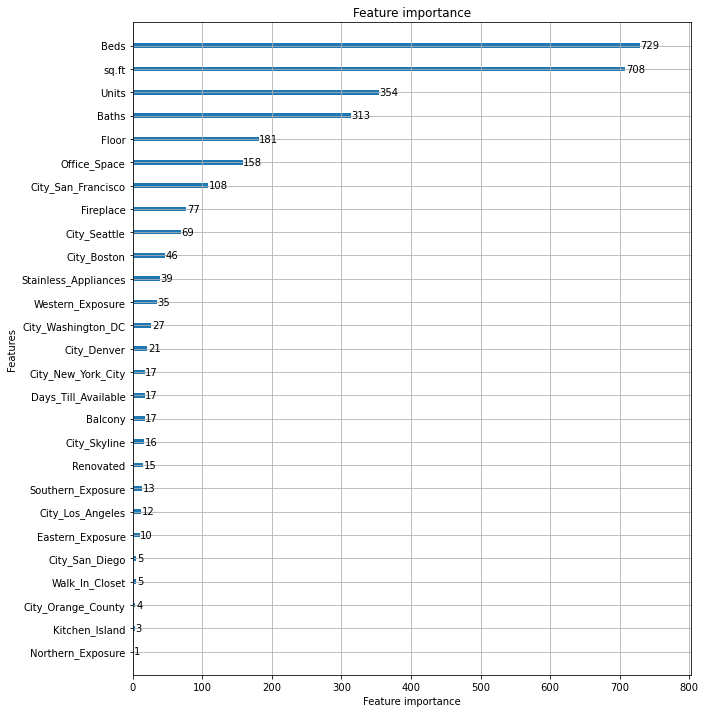

In [43]:
# Plot Feature importance by LGBMRegressor
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_reg, ax=ax)

### Description
As we already saw on the correlation heatmap, beds, sq.ft and baths were important for prediction.  
Additionally, 'units' was also as much important as those features.

# Conclusion
Generally, the price of resdiential areas were most affected by the inside features of each apartment than any other features.  
Unexpectedly, appliances, island of the kitchen and the closet were more lower than I expected.  
Specifically, about 96% of apartments are equipped with 'Kitchen Island', but the importance was remarkably low.  
Therefore, I can say that thesedays people preferr going out for dining to eating away at home.

**Thank you for you reading my Notebook!**  
If you have any other opinions or perspectives, don't hesitate and just commment to my notebook